In [3]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [4]:
vi = 0.01

Vol = vi*10**(-14); NA = 6.02*10**(23); Cal = NA*Vol*10**(-6)

TC = 0.158

kc1 = 0.15*Cal*TC
# production of p53 [molecules/min]

kc2 = 0.1*TC
# degradation of p53 by mdm2 [1/min]

kc3 = 0.1*Cal
# degradation of p53 by mdm2 [molecules]

kc4 = 0.1/Cal*TC
# production of mdm2 - mRNA [1/(molecules*min)]

kc5 = 0.1*TC 
# degradation of mdm2 - mRNA [1/min]

kc6 = 0.2*TC 
# production of mdm2 [1/min]

kc7 = 0.1*TC 
# degradation of mdm2 [1/min]

kc8 = 0.0036 
# binding of mdm2 and nutlin [1/(molecules*min)]

In [5]:
def p_change(t, p, m, Mf, Mb, n):
    dpdt = kc1 - kc2*Mf*(p / (kc3 + p))
    return dpdt

def m_change(t, p, m, Mf, Mb, n):
    dmdt = (kc4 * p**2 - kc5 * m)
    return dmdt

def M_free_change(t, p, m, Mf, Mb, n):
    dM_freedt = kc6 * m - kc7 * Mf - kc8*n*Mf
    return dM_freedt

def M_bound_change(t, p, m, Mf, Mb, n):
    dM_bounddt = - kc7*Mb + kc8*n*Mf
    return dM_bounddt

def n_change(t, p, m, Mf, Mb, n):
    dndt = -kc8*n*Mf
    return dndt

def samlet_system(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = p_change(t, *y)
    dydt[1] = m_change(t, *y)
    dydt[2] = M_free_change(t, *y)
    dydt[3] = M_bound_change(t, *y)
    dydt[4] = n_change(t, *y)
    return dydt

In [6]:
t_samlet = (0, 5000)

p0, m0, Mf0, Mb0, n0 = 100, 1, 1, 1, 1

y0 = [p0, m0, Mf0, Mb0, n0]

In [7]:
samlet_løsning = solve_ivp(samlet_system, t_samlet, y0, method='RK45')
print(samlet_løsning)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.698e-02 ...  4.989e+03  5.000e+03]
        y: [[ 1.000e+02  1.001e+02 ...  6.308e+01  6.877e+01]
            [ 1.000e+00  1.253e+00 ...  3.343e+01  3.945e+01]
            ...
            [ 1.000e+00  9.988e-01 ... -7.076e-07 -1.458e-07]
            [ 1.000e+00  9.997e-01 ...  6.556e-07  1.346e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4148
     njev: 0
      nlu: 0


In [8]:
time_transient, p_transient, m_transient, Mf_transient, Mb_transient, n_transient = samlet_løsning["t"], samlet_løsning["y"][0], samlet_løsning["y"][1], samlet_løsning["y"][2], samlet_løsning["y"][3], samlet_løsning["y"][4]

[]

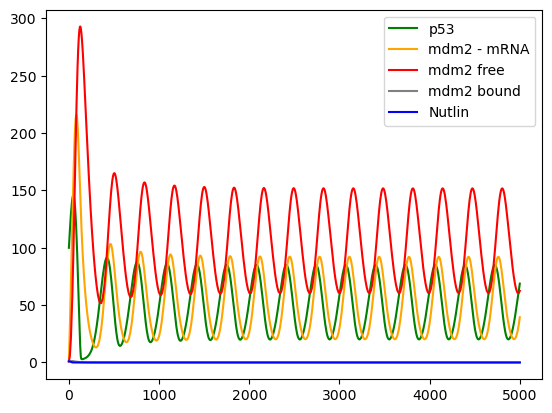

In [9]:
plt.plot(time_transient, p_transient, color="green", label="p53")
plt.plot(time_transient, m_transient, color="orange", label="mdm2 - mRNA")
plt.plot(time_transient, Mf_transient, color="red", label="mdm2 free")
plt.plot(time_transient, Mb_transient, color="gray", label="mdm2 bound")
plt.plot(time_transient, n_transient, color="blue", label="Nutlin")


plt.legend()
plt.plot()

### Peakfinding med scipy

"For several conditions the interval borders can be specified with arrays matching x in shape which enables dynamic constrains based on the sample position."

In [12]:
def find_peaks_transient(t, y):

    y_peaks = find_peaks(y, height=None)[0]
    last_index = y_peaks[-1]

    reference_height = y[last_index]

    return y_peaks, reference_height

In [11]:
def find_peaks_nutlin()

(array([  9,  73, 112, 150, 187, 225, 262, 300, 337, 374, 411, 449, 486,
        523, 561]),
 {})

In [10]:
def compute_internal_oscillator(t, y): #mean, amplitude, period
    y_peaks = find_peaks(y)[0]
    y_troughs = find_peaks(-y)[0]

    # Only keep peaks after the 10 first peaks. We assume that the period and amplitude will be approx. stable after this.
    stable_peaks = None
    stable_troughs = None
    if len(y_peaks) > 12 and len(y_peaks) > len(y_troughs):
        stable_peaks = y_peaks[10:-2]
        stable_troughs = y_troughs[10:-1]
    else:
        stable_peaks = y_peaks[10:-1]
        stable_troughs = y_troughs[10:-1]
        
    # Is it true that N is larger when using troughs also? So that the uncertainty is smaller?
    period = np.mean((np.diff(t[stable_peaks]) + np.diff(t[stable_troughs]))/2)
    # TODO: Calculate uncertainty for this!
    
    amplitude = np.mean((y[stable_peaks] - y[stable_troughs])/2)

    mean_value = np.mean(np.concatenate((y[stable_peaks] - amplitude, y[stable_troughs] + amplitude)))

    return period, amplitude, mean_value, stable_peaks, stable_troughs

In [147]:
def compute_oscillator_for_arnold(t, y, minimum_height = None): #mean, amplitude, period
    y_arr = np.array(y)
    t_arr = np.array(t)

    y_peaks = find_peaks(y_arr, height=minimum_height, threshold=5)[0]

    # Only keep peaks after the 10 first peaks. We assume that the period and amplitude will be approx. stable after this.
    stable_peaks = None
    
    if len(y_peaks) > 12:
        stable_peaks = y_peaks[10:-1]
        
    # Is it true that N is larger when using troughs also? So that the uncertainty is smaller?

    avg_period = np.mean(np.diff(t_arr[stable_peaks]))

    periods = np.diff(t_arr[stable_peaks])
    # TODO: Calculate uncertainty for this!
    amplitude = np.mean(y_arr[stable_peaks])

    return periods, avg_period, amplitude, stable_peaks

In [148]:
p_transient

array([100.        , 100.13692225, 101.50579896, 114.93522077,
       129.05122372, 139.73084975, 142.69479007, 144.71598129,
       145.5856071 , 145.78902846, 145.42574217, 144.56937156,
       143.22594055, 141.23717523, 138.28163314, 133.78953137,
       126.82372736, 119.15412033, 111.28699467, 102.56048954,
        95.04012845,  87.09308449,  77.95280844,  69.56994219,
        61.00604466,  52.19378486,  43.68876449,  35.86293179,
        28.56318083,  21.50119827,  14.86309435,   9.44728617,
         5.90765599,   4.04604376,   3.21955747,   2.91760707,
         2.84485098,   2.85828719,   2.90089468,   2.95619152,
         3.02401175,   3.1073714 ,   3.20462319,   3.30962373,
         3.42058838,   3.54490151,   3.69384456,   3.87196953,
         4.07133327,   4.28356763,   4.51687578,   4.7953427 ,
         5.14171376,   5.5564088 ,   6.02173659,   6.54168816,
         7.16722549,   7.9791039 ,   9.03812098,  10.34578886,
        11.90574462,  13.84984709,  16.48669363,  20.21

In [149]:
T_int, A_int, mean_int, stable_peaks_int, stable_troughs_int = compute_internal_oscillator(time_transient, p_transient)

In [150]:
stable_peaks_int

array([411, 449, 486, 523])

Text(0.5, 1.0, 'Oscillationer af p53 koncentration med perioden T = 329.1 [min]')

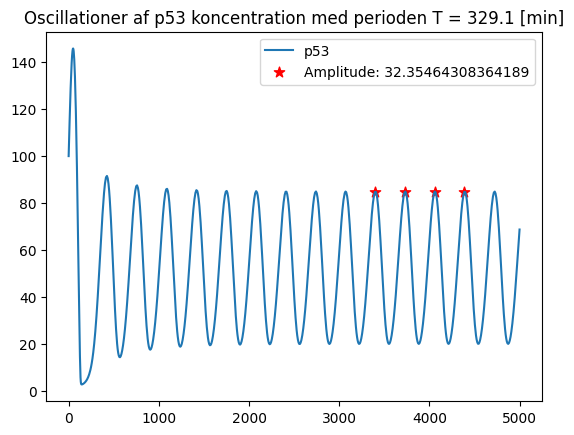

In [151]:
plt.plot(time_transient, p_transient, label="p53")
plt.scatter(time_transient[stable_peaks_int], p_transient[stable_peaks_int], s=60, c="red", marker='*', label=f"Amplitude: {A_int}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {T_int:.4} [min]")

In [152]:
def sim_onoff_nutlin(oscillationer, T_int, OOmega, p0, m0, Mf0, Mb0, A_ext):
    # This is correct, and it is working! Remember to count in period values, not frequency! If you count in frequency, you are counting the reciprocal.
    T_ext = OOmega * T_int
    omega = T_int / T_ext

    history = {"t":[] ,"p": [], "m": [], "Mf": [], "Mb":[], "n":[]}

    # TODO: Undersøg max_step i fremtiden
    for i in range(oscillationer):
        if i == 0:
            state = p0, m0, Mf0, Mb0, A_ext
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t)
            history["p"].extend(p)
            history["m"].extend(m)
            history["Mf"].extend(Mf)
            history["Mb"].extend(Mb)
            history["n"].extend(n)
        
        # Every period, Nutlin concentration is reset to A_ext
        state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], A_ext
        sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
        t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        history["t"].extend(t + history["t"][-1])
        history["p"].extend(p)
        history["m"].extend(m)
        history["Mf"].extend(Mf)
        history["Mb"].extend(Mb)
        history["n"].extend(n)
        
        # TODO: Off one period, on one period
        # Nutlin turned off for one period
        # elif i % 2 == 0:
        #     state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], 0
        #     sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5)
        #     t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        #     history["t"].extend(t + history["t"][-1])
        #     history["p"].extend(p)
        #     history["m"].extend(m)
        #     history["Mf"].extend(Mf)
        #     history["Mb"].extend(Mb)
        #     history["n"].extend(n)

        # # Nutlin turned on for one period
        # else:
        #     state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], A_ext
        #     sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5)
        #     t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        #     history["t"].extend(t + history["t"][-1])
        #     history["p"].extend(p)
        #     history["m"].extend(m)
        #     history["Mf"].extend(Mf)
        #     history["Mb"].extend(Mb)
        #     history["n"].extend(n)
    
    return history, omega, T_ext

# Omega and $A_{ext}$

In [153]:
OOmega = 1.5
Nutlin_A = A_int*10

In [154]:
nutlin_sim1, omega, T_ext_sim1 = sim_onoff_nutlin(50, T_int, OOmega, p_transient[-1], m_transient[-1], Mf_transient[-1], Mb_transient[-1], Nutlin_A)

In [155]:
t_1, p_1, m_1, Mb_1, Mf_1, n_1 = np.array(nutlin_sim1["t"]), np.round(np.array(nutlin_sim1["p"]), 4), np.round(np.array(nutlin_sim1["m"]), 4), np.round(np.array(nutlin_sim1["Mb"]), 4), np.round(np.array(nutlin_sim1["Mf"]), 4), np.round(np.array(nutlin_sim1["n"]), 4)

In [156]:
_, _, _, peaks_p53_after_transient, _ = compute_internal_oscillator(np.array(t_1), np.array(p_1))

In [157]:
type(peaks_p53_after_transient)

numpy.ndarray

In [158]:
# Verify the type of elements in peaks_p53_after_transient
print(peaks_p53_after_transient.dtype)

# If it's not an integer type, you should convert it
if peaks_p53_after_transient.dtype != 'int':
    peaks_p53_after_transient = peaks_p53_after_transient.astype(int)

int64


In [159]:
print("t_1 length:", len(t_1))
print("p_1 length:", len(p_1))
print("Max index in peaks:", max(peaks_p53_after_transient))
print("t_1 shape:", t_1.shape)
print("p_1 shape:", p_1.shape)

t_1 length: 6465
p_1 length: 6465
Max index in peaks: 6328
t_1 shape: (6465,)
p_1 shape: (6465,)


Text(0.5, 1.0, 'Oscillationer af p53 koncentration med perioden T = 329.1 [min]')

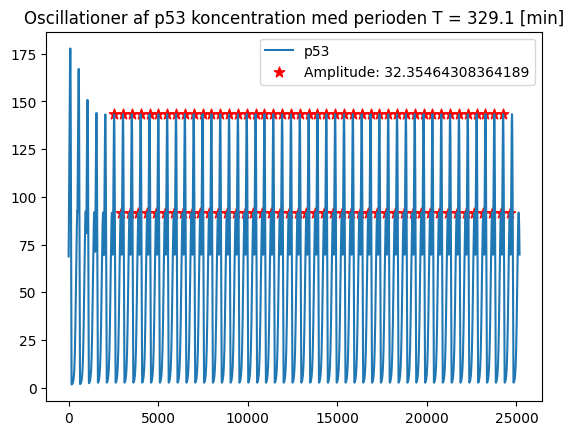

In [160]:
plt.plot(t_1, p_1, label="p53")
plt.scatter(t_1[peaks_p53_after_transient], p_1[peaks_p53_after_transient], s=60, c="red", marker='*', label=f"Amplitude: {A_int}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {T_int:.4} [min]")

In [161]:
len(t_1)

6465

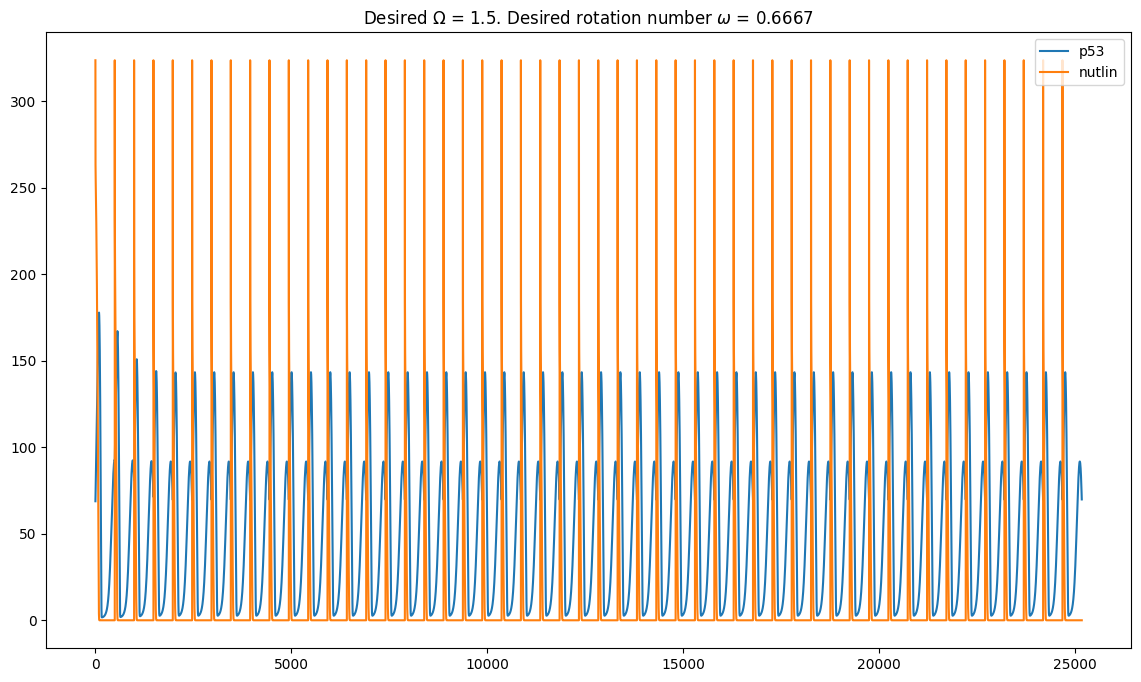

In [162]:
plt.figure(figsize=(14, 8))

plt.plot(t_1, p_1, label="p53")
plt.plot(t_1, n_1, label="nutlin")
# plt.plot(t_1, m_1, label="mRNA")
# plt.plot(t_1, Mb_1, label="Mb")
# plt.plot(t_1, Mf_1, label="Mf")

plt.title(rf"Desired $\Omega$ = {OOmega}. Desired rotation number $\omega$ = {omega:.4}")

plt.legend()

# plt.title(f"Oscillationer af p53 koncentration med perioden T = {period:.4} [min]")

[]

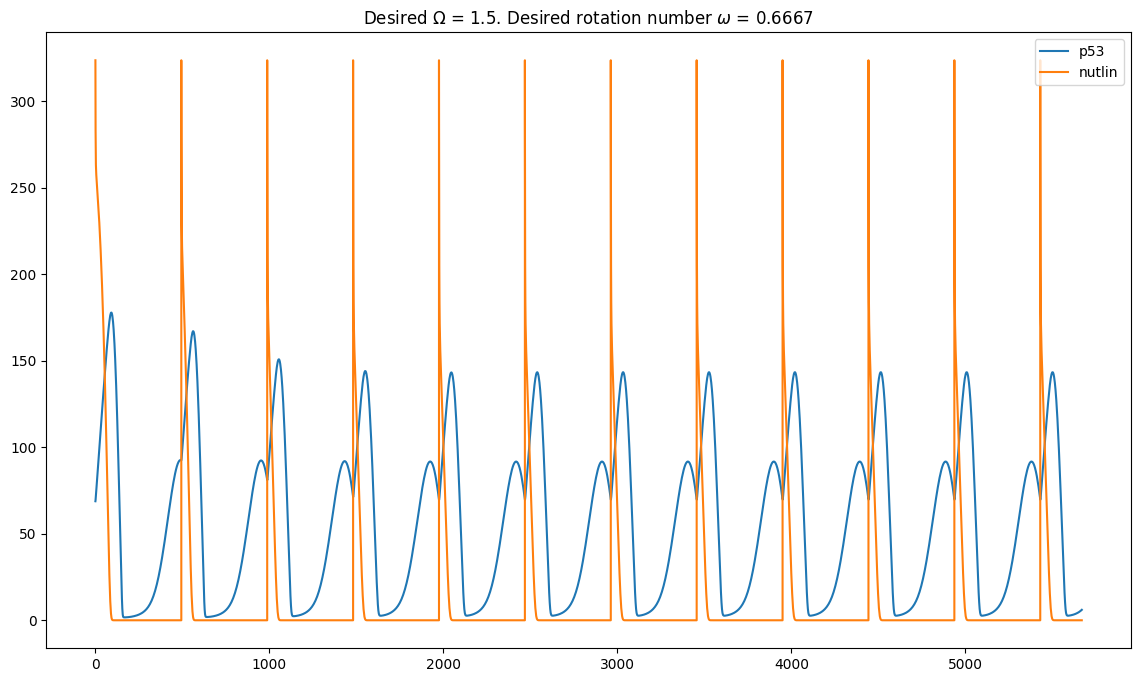

In [163]:
plt.figure(figsize=(14, 8))

plt.plot(t_1[:1500], p_1[:1500], label="p53")
plt.plot(t_1[:1500], n_1[:1500], label="nutlin")

# for i in range(len(peaks_nutlin)):
#     plt.scatter(t_1[peaks_nutlin[i]], n_1[peaks_nutlin[i]], c="red", marker='*')

# for i in range(len(troughs_p53)):
#     plt.scatter(t_1[troughs_p53[i]], p_1[troughs_p53[i]], c="black", marker='*')

plt.title(rf"Desired $\Omega$ = {OOmega}. Desired rotation number $\omega$ = {omega:.4}")

plt.legend()
plt.plot()

# Arnold Tongue plot

Først vil vi udregne om der er entrainment eller ej.

In [164]:
# Ranges for A_ext og Omega

Omegas = np.linspace(0, 4, 100)
A_externals = np.linspace(0, 1, 100) # The upper bound is A_int * upper bound = A_ext

In [190]:
def calculate_entrainment(time, p53, nutlin, cutoff):
    T_arr_p53, T_p53, A_p53, stable_peaks_p53 = compute_oscillator_for_arnold(time[-cutoff:], p53[-cutoff:], minimum_height=None)
    T_p53_rounded = np.round(T_arr_p53, 4)
    print(T_p53_rounded)

    # T_arr_nutlin = np.ones(len(T_arr_p53))*T_ext_sim1

    T_arr_nutlin, T_nutlin, A_nutlin, stable_peaks_nutlin = compute_oscillator_for_arnold(time[-cutoff:], nutlin[-cutoff:], minimum_height=Nutlin_A * 0.95)
    print(T_arr_nutlin[-100:])

    T_p53_last = None
    T_nutlin_last = None
    if len(T_arr_nutlin) < len(T_arr_p53) + 1:
        T_p53_last = T_arr_p53[-len(T_arr_nutlin):]
        T_nutlin_last = T_arr_nutlin.copy()
    else:
        T_nutlin_last = T_arr_nutlin[-len(T_arr_p53):]
        T_p53_last = T_arr_p53.copy()

    # print(np.divide(T_nutlin_last, T_p53_last))

    return T_p53_last, T_nutlin_last


In [191]:
T_arr_p53, T_arr_nutlin = calculate_entrainment(np.array(t_1), np.array(p_1), np.array(n_1), 100000)

[[0.000e+00 3.000e-04 2.700e-03 ... 5.000e+00 5.000e+00 4.982e+00]]
[[2.74668115e-05 2.74668115e-04 2.74668115e-03 ... 5.00000000e+00
  5.00000000e+00 4.98199493e+00]]


In [177]:

# print(len(T_arr_p53), len(T_arr_p53), actual_omega)
actual_omega

array([[1., 1., 1., ..., 1., 1., 1.]])

In [167]:
x_dummy = np.arange(len(T_arr_p53))

In [168]:
print(len(T_arr_nutlin), len(T_arr_p53))

1 1


In [169]:
plt.plot(x_dummy, T_arr_p53, label=r"P53")
# plt.plot(x_dummy, np.round(T_arr_nutlin, 8), label=r"Nutlin")

# plt.ylim(bottom=200)

plt.legend()

plt.title(f"Variation i periode?")

Text(0.5, 1.0, 'Variation i periode?')

ValueError: Image size of 534x135438 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [170]:

plt.plot(x_dummy[:100], np.round(actual_omega[:100],3), label=r"$\Omega$")

# plt.ylim(bottom=200)

plt.legend()

plt.title(f"Faktisk Omega")

Text(0.5, 1.0, 'Faktisk Omega')

ValueError: Image size of 556x135438 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>